In [2]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('/Users/arimorcos/Github/getRedditDataset/')
#sys.path.append('D:\Documents\GitHub\getRedditDataset')
#from celebReddit import countWords
import redditDB
import datetime
import praw
from matplotlib import pyplot as pp
from matplotlib import colorbar as cb
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as PD
import scipy
from scipy import spatial
from sklearn import cluster, decomposition
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def addCopyright(ax, xOffset=0, yOffset=0):
    year = datetime.date.today().year
    if any([i == '_axis3don' for i in dir(ax)]):
        ax.text(0 + xOffset, -.05 + yOffset, 0, r'$\copyright$ Ari Morcos  ' + str(year), transform=ax.transAxes)
    else: 
        ax.text(0 + xOffset, -.05 + yOffset, r'$\copyright$ Ari Morcos  ' + str(year), transform=ax.transAxes)

In [4]:
""" Establish database connection """
db = redditDB.RedditDB('March2-8_Top200')

In [5]:
""" Get comments from subreddits """
if not os.path.isfile('popSubs.npy'):
    subList = praw.Reddit(user_agent='pop').get_popular_subreddits(limit=200)
    subList = [sub.display_name for sub in subList]
    np.save('popSubs.npy', subList)
else:
    subList = list(np.load('popSubs.npy'))
comments = db.getSubredditCommentText(subList[0])

In [6]:
""" Strip formatting """ 
comments = [''.join(s for s in comment if ord(s)>31 and ord(s)<126) for comment in comments]

In [7]:
""" Enumerate words to get list and values """
def countNWords(allWords):
    wordCounts = {}
    for word in allWords:
        if word in wordCounts:
            wordCounts[word] += 1 
        else: 
            wordCounts[word] = 1
    return wordCounts

In [8]:
""" Concatenate all comments together and split into individual words """ 
allComments = " ".join(comments)
allWords = allComments.split()
allWords = [word.lower() for word in allWords]
wordCounts = countNWords(allWords)

In [9]:
""" sort by values and get 100 most frequent words""" 
sortedWords = sorted(wordCounts, key=wordCounts.get, reverse=True)
mostFreqWords = sortedWords[0:100]

In [10]:
freqWordCounts = [wordCounts[word] for word in mostFreqWords]

In [11]:
reload = False
usedSubs = subList[0:50]

if not os.path.isfile('allCounts.npy') or reload:

    allCounts = np.zeros(shape=(len(mostFreqWords) ,len(usedSubs)))
    subInd = 0
    for sub in usedSubs: 

        # get comments 
        comments = db.getSubredditCommentText(sub)
        comments = [''.join(s for s in comment if ord(s)>31 and ord(s)<126) for comment in comments]

        # convert to all words
        allComments = " ".join(comments)
        allWords = allComments.split()
        allWords = [word.lower() for word in allWords]

        # count words 
        wordCounts = countNWords(allWords)

        # get total words 
        totWords = float(len(allWords))

        # get freqWordCounts 
        freqWordCounts = [wordCounts[word] if word in wordCounts else 0 for word in mostFreqWords ]
        freqWordCounts = [i/totWords for i in freqWordCounts]

        # concatenate 
        allCounts[:,subInd] = freqWordCounts

        # increment subInd
        subInd += 1    
        
    # save
    np.save('allCounts',allCounts)
else:
    allCounts = np.load('allCounts.npy')

In [12]:
""" get pairwise distance """
normMax = np.max(allCounts, axis=1)
normCounts = np.transpose(np.divide(np.transpose(allCounts), normMax))
distVec = spatial.distance.pdist(np.transpose(normCounts), 'euclidean')
distMat = spatial.distance.squareform(distVec)

In [13]:
""" print top words """ 
print '100 Most Frequent Words'
for word, ind in zip(mostFreqWords, range(len(mostFreqWords))):
    print str(ind+1) + ': ' + word 

100 Most Frequent Words
1: the
2: a
3: to
4: i
5: and
6: of
7: is
8: you
9: that
10: it
11: in
12: this
13: for
14: was
15: on
16: my
17: have
18: like
19: with
20: not
21: be
22: just
23: but
24: are
25: they
26: it's
27: he
28: your
29: if
30: so
31: at
32: as
33: or
34: what
35: one
36: me
37: all
38: get
39: don't
40: would
41: can
42: i'm
43: when
44: from
45: an
46: about
47: do
48: we
49: his
50: out
51: up
52: how
53: no
54: people
55: that's
56: more
57: think
58: there
59: some
60: because
61: know
62: had
63: has
64: who
65: by
66: only
67: their
68: she
69: then
70: really
71: than
72: them
73: it.
74: will
75: you're
76: see
77: even
78: why
79: got
80: time
81: did
82: were
83: make
84: could
85: good
86: go
87: never
88: her
89: been
90: those
91: still
92: other
93: where
94: actually
95: also
96: much
97: looks
98: going
99: want
100: didn't


In [14]:
%matplotlib qt
fig, ax = pp.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
axMat = ax.matshow(distMat)
ax.set_xticks(range(len(distMat)))
ax.set_xticklabels(subList, rotation=90);
ax.set_yticks(range(len(distMat)))
ax.set_yticklabels(subList);
cbar = fig.colorbar(axMat, shrink=0.8)
cbar.set_label('Euclidean distance')
addCopyright(ax)

In [15]:
""" Plot most 10 most similar pairs"""
x = distMat.copy()
np.fill_diagonal(x, np.inf)
for ind in range(30):
    minInd = np.argmin(x)
    inds = np.unravel_index(minInd, distMat.shape)
    print usedSubs[inds[0]] + ', ' + usedSubs[inds[1]] + ': ' + str(x[inds])
    x[inds] = np.inf
    x[inds[1], inds[0]] = np.inf

pics, WTF: 0.543759113231
worldnews, politics: 0.599345581854
leagueoflegends, DotA2: 0.601210671981
funny, WTF: 0.602313380524
funny, gifs: 0.621706933305
gifs, videos: 0.626716585181
funny, pics: 0.640588437023
funny, videos: 0.651860141535
WTF, videos: 0.693787405031
worldnews, news: 0.703743248721
news, politics: 0.706332605302
GlobalOffensive, DotA2: 0.70882878253
pics, videos: 0.710356004246
leagueoflegends, GlobalOffensive: 0.716566799853
pics, gifs: 0.717228536034
gifs, WTF: 0.723489229483
soccer, nba: 0.751889065628
pics, mildlyinteresting: 0.783822840038
gaming, pokemon: 0.796209985884
nfl, hockey: 0.799350222545
soccer, hockey: 0.821293217825
nba, nfl: 0.827574873963
WTF, mildlyinteresting: 0.841931458449
nba, hockey: 0.856905008487
funny, Jokes: 0.887100200675
news, atheism: 0.924369948462
funny, mildlyinteresting: 0.925252089592
funny, reactiongifs: 0.931403241427
DotA2, hearthstone: 0.934018748533
leagueoflegends, hearthstone: 0.965835121013


In [16]:
""" Plot most 10 most dissimilar pairs"""
x = distMat.copy()
np.fill_diagonal(x, -1*np.inf)
for ind in range(30):
    maxInd = np.argmax(x)
    inds = np.unravel_index(maxInd, distMat.shape)
    print usedSubs[inds[0]] + ', ' + usedSubs[inds[1]] + ': ' + str(x[inds])
    x[inds] = -1*np.inf
    x[inds[1], inds[0]] = -1*np.inf

thewalkingdead, circlejerk: 3.72546853929
gentlemanboners, circlejerk: 3.63429059482
Celebs, circlejerk: 3.51177898884
atheism, circlejerk: 3.45955903137
tumblr, circlejerk: 3.45577212578
CitiesSkylines, circlejerk: 3.45192167389
DestinyTheGame, circlejerk: 3.4319856229
nba, circlejerk: 3.42767314984
cringepics, circlejerk: 3.42654051308
nfl, circlejerk: 3.4203558873
TrollXChromosomes, circlejerk: 3.40431403526
tifu, circlejerk: 3.3686961706
technology, circlejerk: 3.34521983014
GlobalOffensive, circlejerk: 3.33084585987
science, circlejerk: 3.32799725149
Showerthoughts, circlejerk: 3.32153626566
trees, circlejerk: 3.32067892558
SquaredCircle, circlejerk: 3.32063189186
worldnews, circlejerk: 3.30517637544
TumblrInAction, circlejerk: 3.30423636681
reactiongifs, circlejerk: 3.28984964383
woahdude, circlejerk: 3.28281824828
soccer, circlejerk: 3.28108418512
movies, circlejerk: 3.27862732158
news, circlejerk: 3.26794021605
fatpeoplehate, circlejerk: 3.26387350263
leagueoflegends, circlejer

In [17]:
""" perform pca """
pcaObj = decomposition.PCA()
reducedCounts = pcaObj.fit_transform(normCounts.transpose())[:,0:3]

In [18]:
""" plot cumsum of variance explained """ 
varExp = np.cumsum(pcaObj.explained_variance_ratio_)
fig = pp.figure(figsize=(15,15))
ax = pp.subplot()
ax.plot(varExp, marker='o');
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Cumulative variance explained")
ax.set_ylim(bottom=0, top=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(20)
addCopyright(ax)
varExp

array([ 0.20316678,  0.34249536,  0.47170764,  0.5771863 ,  0.67041097,
        0.71971478,  0.75868145,  0.78657188,  0.80981824,  0.83268374,
        0.85208809,  0.8700489 ,  0.88474778,  0.89680366,  0.90809964,
        0.91744568,  0.92543176,  0.93280897,  0.93949886,  0.94547816,
        0.95133216,  0.95612597,  0.96039617,  0.96449796,  0.96831305,
        0.97195273,  0.9752495 ,  0.97820604,  0.98058286,  0.98286532,
        0.98495464,  0.98697203,  0.98870321,  0.99031143,  0.99159251,
        0.99273462,  0.99378325,  0.99471076,  0.99556403,  0.99628621,
        0.99698851,  0.9975928 ,  0.99818327,  0.99859148,  0.99899589,
        0.99930522,  0.999591  ,  0.99982449,  1.        ,  1.        ])

In [19]:
""" cluster points """
apObj = cluster.AffinityPropagation(damping=0.75)
apObj.fit(reducedCounts);
len(set(apObj.labels_))

7

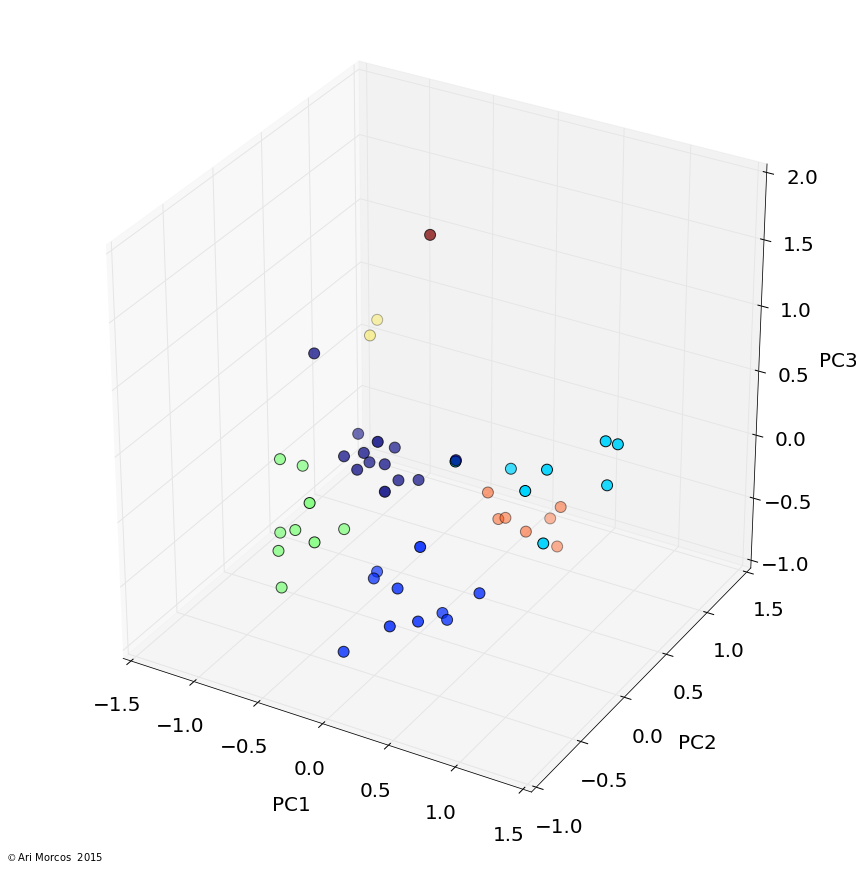

In [20]:
# plot 3d
#%matplotlib qt
%matplotlib inline
fig = pp.figure(figsize=(15,15))
ax = pp.subplot(projection='3d')
ax.scatter(reducedCounts[:,0], reducedCounts[:,1], reducedCounts[:,2], s=120, c=apObj.labels_)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
        item.set_fontsize(20)
addCopyright(ax)

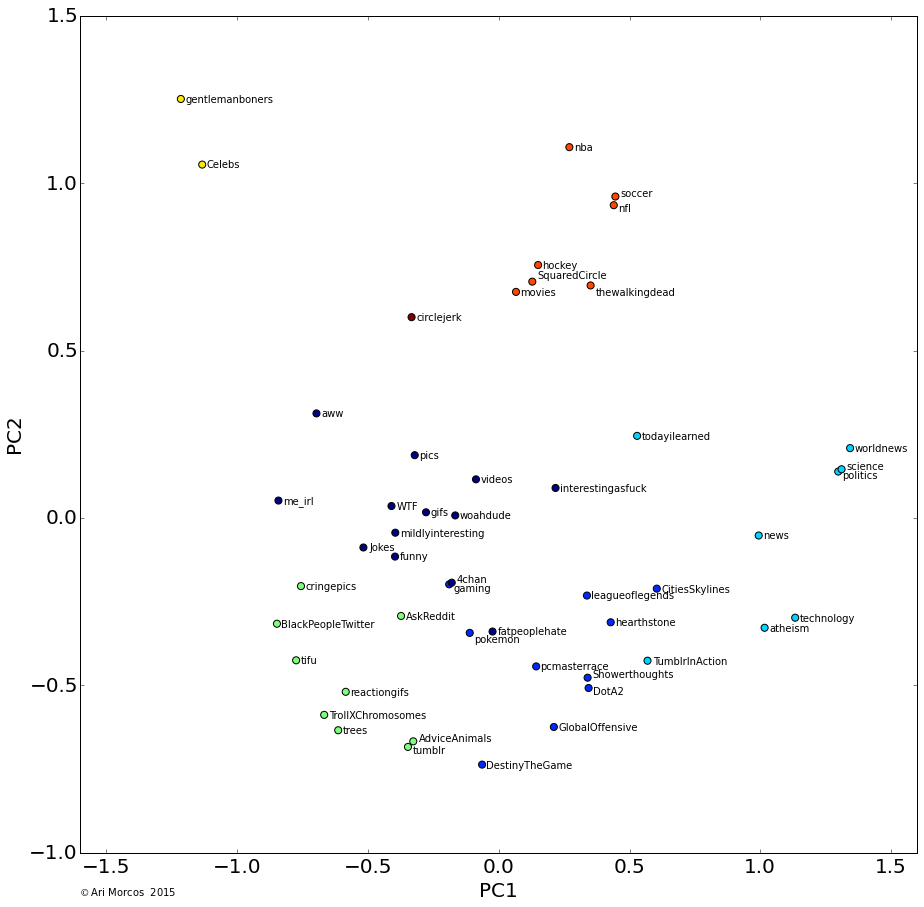

In [22]:
%matplotlib inline
#plot 2d 
fig = pp.figure(figsize=(15,15))
ax2 = pp.subplot()
ax2.scatter(reducedCounts[:,0], reducedCounts[:,1], s=50, c=apObj.labels_)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2')

# get distance between all points
dists = spatial.distance.squareform(spatial.distance.pdist(reducedCounts[:,0:2], 'euclidean'))
np.fill_diagonal(dists,np.inf)

# label points 
for point in range(len(usedSubs)):
    yOffset = 0
    if any(np.argwhere(dists[point,:] < 0.05)):
        yOffset = 0.01
        if reducedCounts[point,1] < reducedCounts[np.argwhere(dists[point,:] < 0.05),1]:
            yOffset = -1*yOffset
    if point == 37 or point == 23:  # ALL THE KLUGE
        yOffset = -0.02
    elif point == 27:
        yOffset = 0.02
    ax2.text(reducedCounts[point,0]+0.02, reducedCounts[point,1]+yOffset, usedSubs[point],
             size=10, rotation=0, va='center', ha='left')
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
                 ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(20)
ax2.set_xlim(left=-1.6, right=1.6)
addCopyright(ax2)

In [ ]:
""" animate """ 
shouldSave = False

def animate(i, ax):
    newVal = i*5
    if newVal > 360:
        newVal = 0
    ax.azim = newVal

import matplotlib.animation as animation
%matplotlib qt
%pylab qt
fig = pp.figure(figsize=(10,10))
ax = pp.subplot(projection='3d')
ax.scatter(reducedCounts[:,0], reducedCounts[:,1], reducedCounts[:,2], s=120, c=apObj.labels_)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, ax.zaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels() + ax.get_zticklabels()):
        item.set_fontsize(20)
addCopyright(ax)
ax.elev = 20
ani = animation.FuncAnimation(fig, animate, fargs=[ax], frames=range(int(72)), interval=175)

if shouldSave: 
    pp.rcParams['animation.ffmpeg_path'] = 'C:\\FFMPEG\\bin\\ffmpeg.exe'
    pp.rcParams['animation.mencoder_path'] = 'C:\\Mencoder\\mencoder.exe'
    Writer = animation.FFMpegWriter()
    ani.save('D:\\Dropbox\\Website\\Blog Posts\\201503\\Clustering subreddits\\pc3DAnimation.avi', 
             writer=Writer, dpi=300, savefig_kwargs={'transparent': True})
    print('Saved file: complete!')

In [38]:
""" plot normalized word distribution """ 
def plotBarNormFreq(normCounts, barSubs, usedSubs):

    # get meanCounts 
    meanNormCounts = np.mean(normCounts, axis=1)

    #generate colors 
    colors = 'brgmy'

    fig, ax = pp.subplots(figsize=(15,15))
    handles = []
    width = 1./(len(barSubs))
    for sub, ind in zip(barSubs, range(len(barSubs))):

        # normalize 
        tempNorm = normCounts[:,usedSubs.index(barSubs[ind])]/meanNormCounts

        # sort 
        sortedNorm = sorted(tempNorm, reverse=True)
        sortOrder = [i[0] for i in sorted(enumerate(tempNorm), key=lambda x:x[1], reverse=True)]

        # plot bar 
        handles.append(ax.bar([i + -0.5*width + width*ind for i in range(len(mostFreqWords))], 
                               sortedNorm, width=width, color=colors[ind], align='center'))
        
    # plot chance line 
    ax.plot([0, len(mostFreqWords)], [1, 1], ls='--', color='k')

    # label axes 
    ax.set_ylabel('Normalized word frequency')
    ax.set_xticks(range(len(mostFreqWords)));
    ax.set_xticklabels([mostFreqWords[i] for i in sortOrder], rotation=-90);
    ax.set_xlim(left=0-0.5*width, right=len(mostFreqWords)-0.5*width);
    ax.set_title(", ".join(barSubs) + ' Normalized Word Frequency')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_yticklabels()):
        item.set_fontsize(20)
    if len(barSubs) > 1:
        ax.legend(handles, barSubs, loc='upper left');
    addCopyright(ax, yOffset=-0.01)

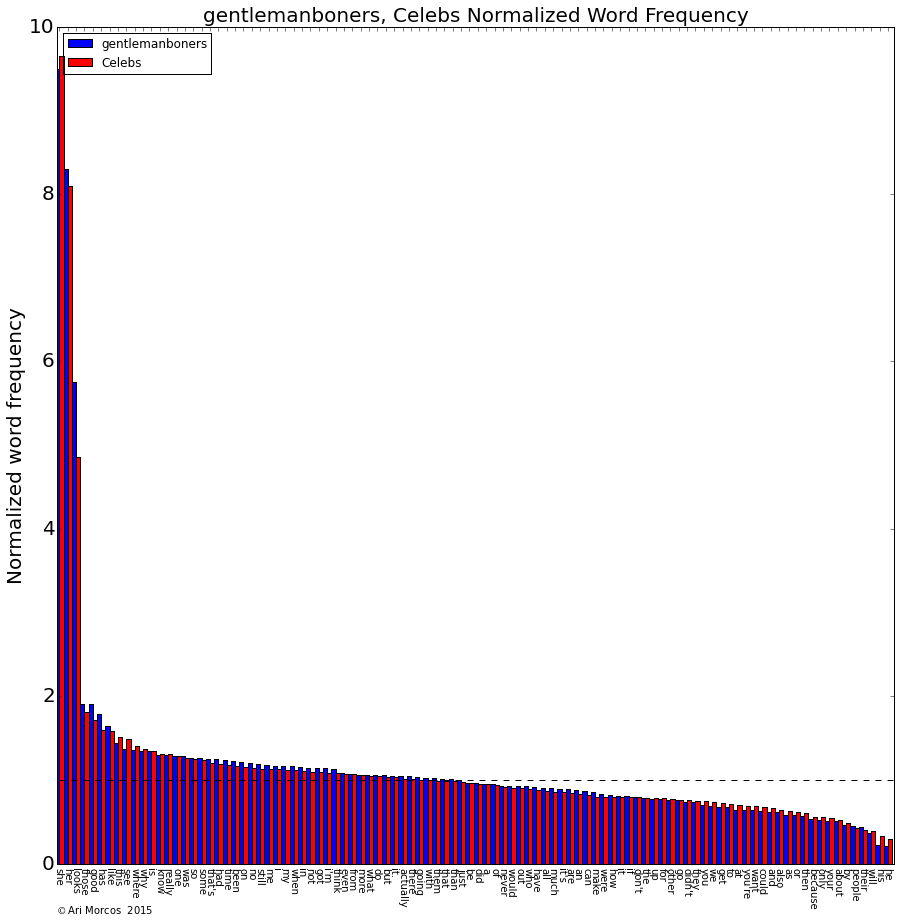

In [39]:
%matplotlib inline
plotBarNormFreq(normCounts, ['gentlemanboners','Celebs'], usedSubs)

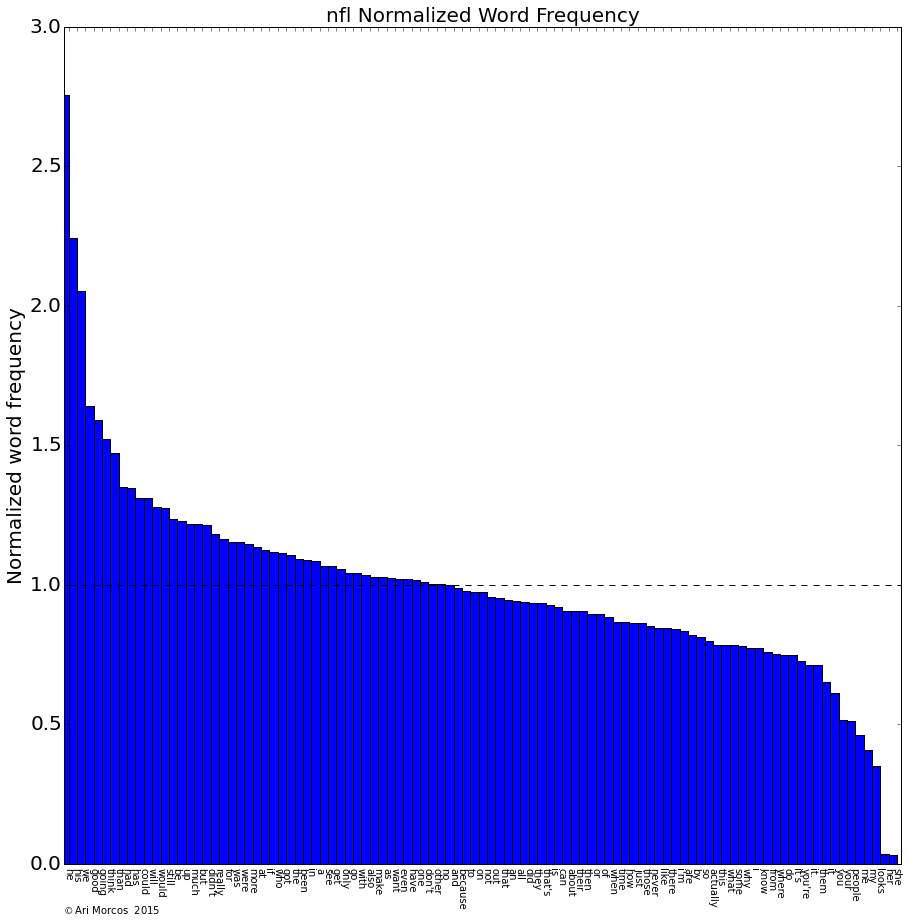

In [40]:
plotBarNormFreq(normCounts, ['nfl'], usedSubs)

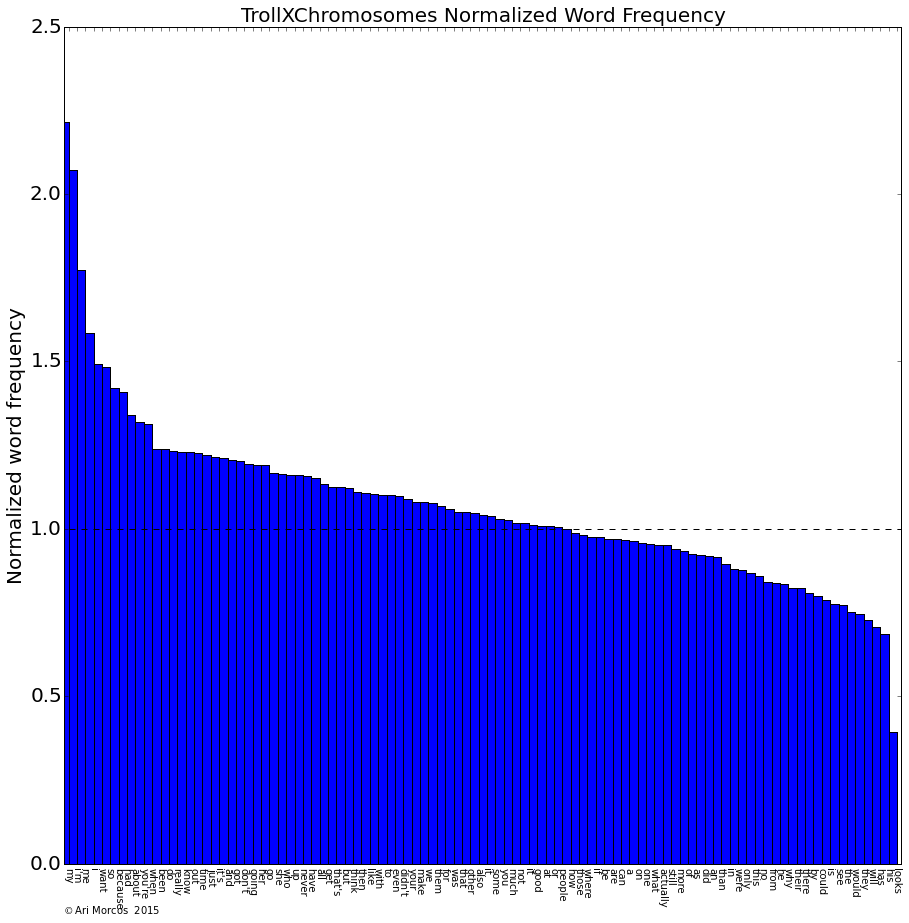

In [41]:
plotBarNormFreq(normCounts, ['TrollXChromosomes'], usedSubs)

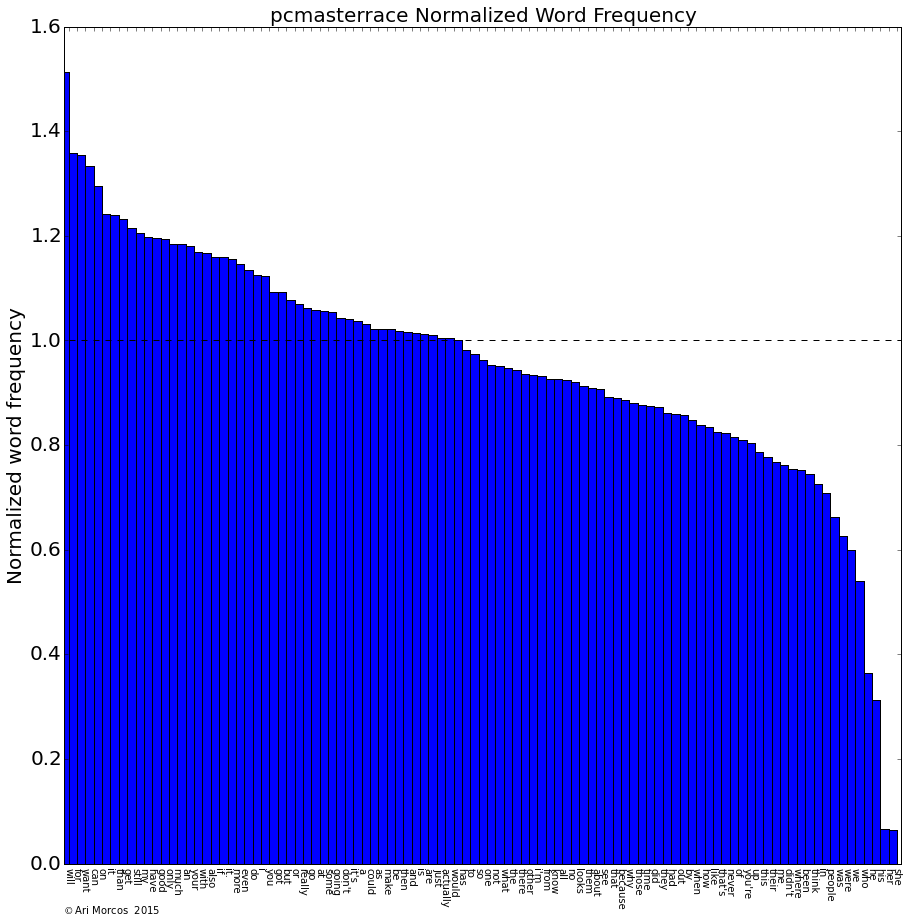

In [42]:
plotBarNormFreq(normCounts, ['pcmasterrace'], usedSubs)

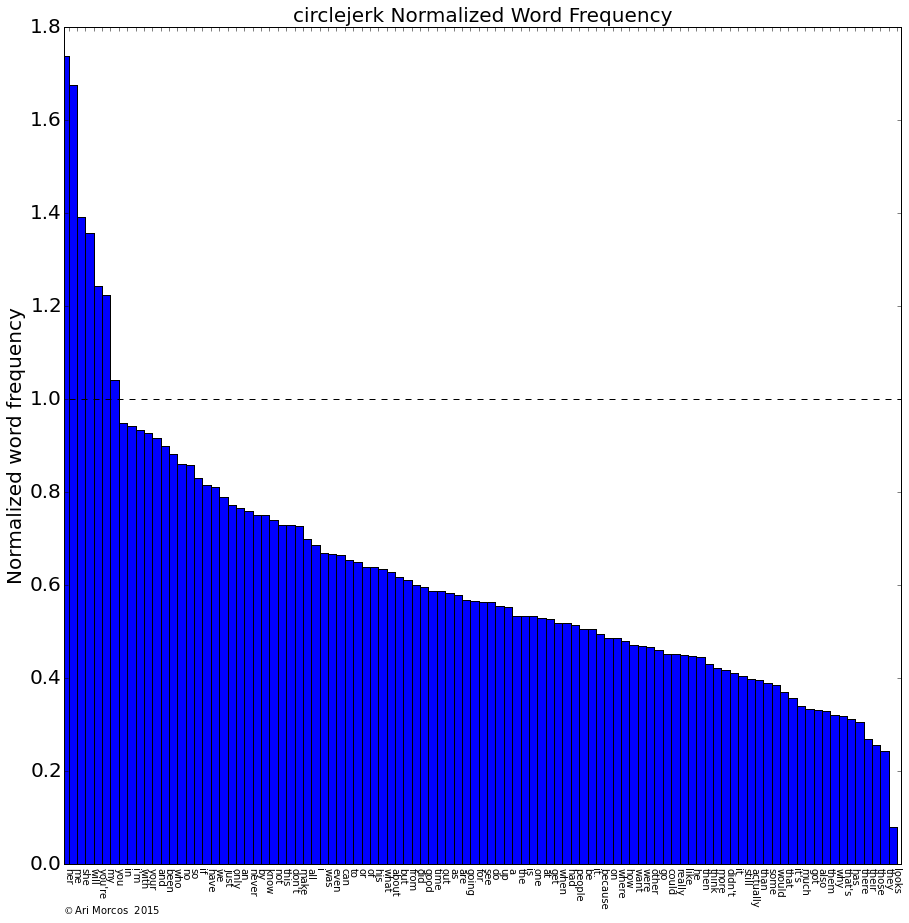

In [43]:
plotBarNormFreq(normCounts, ['circlejerk'], usedSubs)

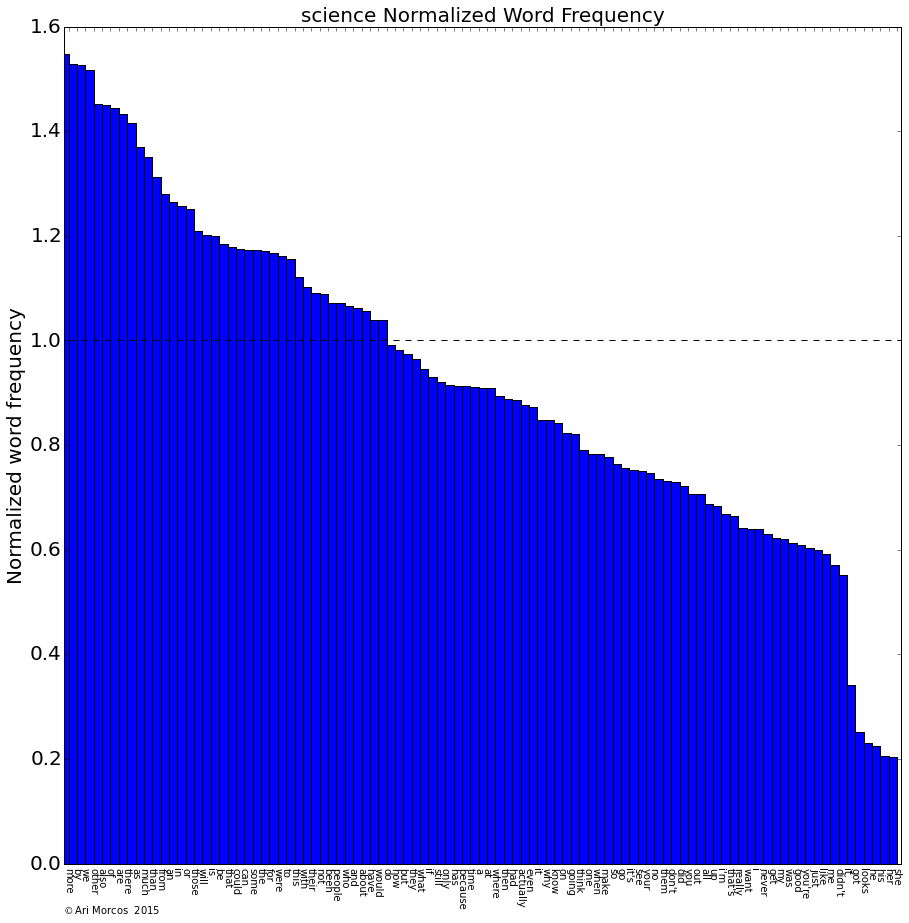

In [45]:
plotBarNormFreq(normCounts, ['science'], usedSubs)

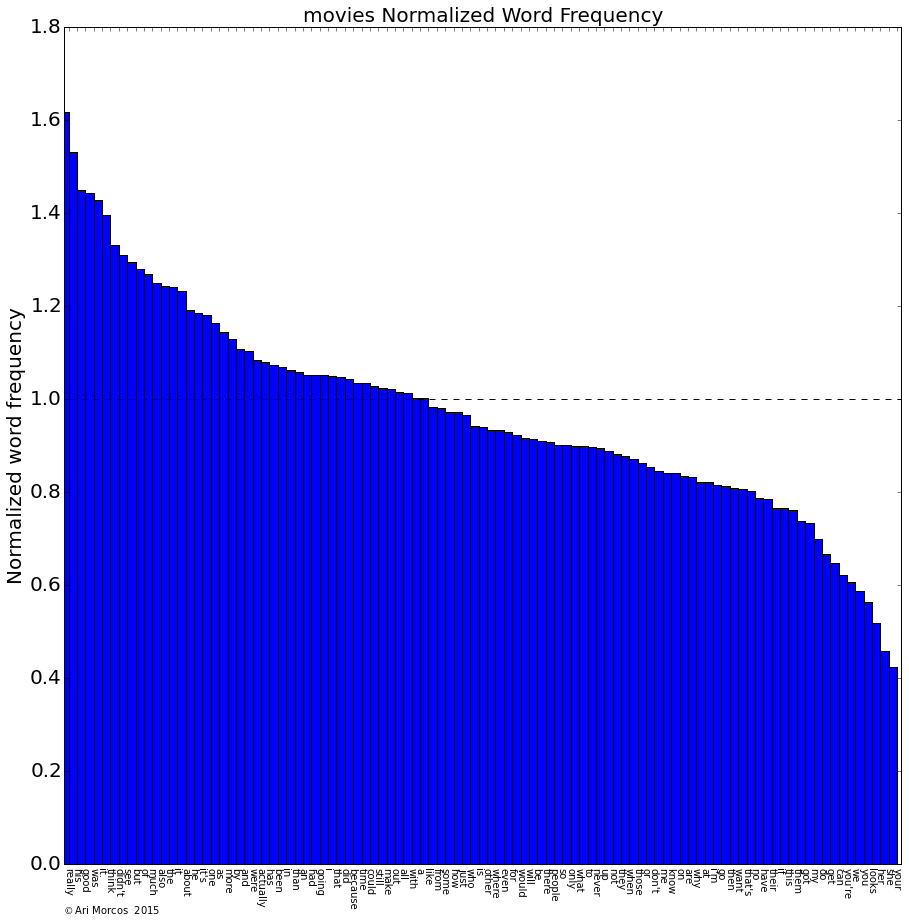

In [44]:
plotBarNormFreq(normCounts, ['movies'], usedSubs)

In [ ]:
""" plot pcs themselves """ 
%matplotlib inline
pcaObj.components_

barSubs = ['PC 1', 'PC 2', 'PC 3']
barSubs = ['PC 1']


#generate colors 
colors = 'brgmy'

fig, ax = pp.subplots(figsize=(15,15))
handles = []
width = 1
for sub, ind in zip(barSubs, range(len(barSubs))):

    # normalize 
    tempNorm = np.sum(np.abs(pcaObj.components_[0:2,:]), axis=0)
    
    # sort 
    sortedNorm = sorted(tempNorm, reverse=True)
    sortOrder = [i[0] for i in sorted(enumerate(tempNorm), key=lambda x:x[1], reverse=True)]

    # plot bar 
    handles.append(ax.bar([i + ind for i in range(len(mostFreqWords))], 
                           sortedNorm, width=width, color=colors[ind], align='center'))

# label axes 
ax.set_ylabel('Summed principal component contribution (a.u.)')
ax.set_xticks(range(len(mostFreqWords)));
ax.set_xticklabels([mostFreqWords[i] for i in sortOrder], rotation=-90);
ax.set_xlim(left=0-0.5*width, right=len(mostFreqWords)-0.5*width);
#ax.set_title('PC contributions')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_yticklabels()):
    item.set_fontsize(20)
addCopyright(ax, yOffset=-0.02)